## Fix demuxing
of temperature replica exchange trajectories for oligomers

In [1]:
import time, os
import numpy as np
import MDAnalysis as mda
from scipy.spatial import distance
import matplotlib.pyplot as plt

### basic function: `demuxing`

`demuxing` will give `replica_index` (columns then `replica_temp = np.argsort(replica_index, axis=1)`

https://gromacs.bioexcel.eu/t/difference-between-replica-index-xvg-and-replica-temp-xvg/5540

- `replica_index` and `replica_temp` are mutually inverse: `replica_temp` shows the diffusion of each replica in temperature space, i.e. each replica (column) is at what temperature; `replica_index` shows the opposite, i.e. each temperature (column) is at which replica

In [2]:
def main_demuxing(x, x_new, threshold = 1e-3, n_replicas = 24, if_assert = True):
    """ this is the inner function of demuxing (NOT imported there) """

    # if (type(my_fun) is float) or (type(my_fun) is int):
    my_fun = lambda x1, x2 : len(np.where(np.abs(x1 - x2) < threshold)[0])
    
    diff = distance.cdist(x, x_new, my_fun)
    """ diff[i, j] is the distance between x[i] and x_new[j] """

    ind = np.argmax(diff, axis=0)
    """ ind[i] is the index of x_new which is the closest to x[i] """

    # you should add a check on unique assignment!
    assert len(np.unique(ind)) == n_replicas
    
    # if len(np.unique(ind)) != n_replicas:
    #     print('error')
    
    return diff, ind

In [3]:
def get_trajectory(n_replicas, paths_traj, start_frame):

    trajs = []

    for n_subtraj in range(len(paths_traj)):
        
        xtc_read = []  # xtc_read[NR][n_frame][:]
        for n_rep in range(n_replicas):
            xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % n_rep))
        
        n_frame0 = start_frame
        
        if n_subtraj == 0:
            x = []
            for n_rep in range(n_replicas):
                x.append(xtc_read[n_rep][start_frame][:].flatten())
            
            trajs.append(np.array(x))
            n_frame0 = start_frame + 1  # if already initialised, start from next frame
        
        len_subtraj = 100  # len(xtc_read[0])
        
        for n_frame in range(n_frame0, len_subtraj):
            x_new = []
            for n_rep in range(n_replicas):
                x_new.append(xtc_read[n_rep][n_frame][:].flatten())

            trajs.append(np.array(x_new))

            if (n_frame % 10) == 0:
                print('n frames: ', n_frame)

        return trajs

In [2]:
from demuxing_fun import demuxing

### select trajectories and do demuxing on those

In [66]:
sequence = 'CCCC'
n_replicas = 24

curr_dir = '/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (sequence, sequence)

# n_max_subtraj = 100  # 310 for UCAAUC, 100 for UCUCGU (?)

# start_frame = 0

In [67]:
paths_traj = [s for s in os.listdir(curr_dir) if s.startswith('traj_comp0')]  #  and s.endswith('0002.xtc'))]

paths_traj

['traj_comp0.part0002.xtc',
 'traj_comp0.part0003.xtc',
 'traj_comp0.part0004.xtc',
 'traj_comp0.part0005.xtc',
 'traj_comp0.part0006.xtc',
 'traj_comp0.part0007.xtc',
 'traj_comp0.part0008.xtc',
 'traj_comp0.part0009.xtc',
 'traj_comp0.part0010.xtc',
 'traj_comp0.part0011.xtc',
 'traj_comp0.part0012.xtc',
 'traj_comp0.part0013.xtc',
 'traj_comp0.part0014.xtc',
 'traj_comp0.part0015.xtc',
 'traj_comp0.part0016.xtc',
 'traj_comp0.part0017.xtc',
 'traj_comp0.part0018.xtc',
 'traj_comp0.part0019.xtc',
 'traj_comp0.part0020.xtc',
 'traj_comp0.part0021.xtc',
 'traj_comp0.part0022.xtc',
 'traj_comp0.part0023.xtc',
 'traj_comp0.part0024.xtc',
 'traj_comp0.part0025.xtc',
 'traj_comp0.part0026.xtc',
 'traj_comp0.part0027.xtc',
 'traj_comp0.part0028.xtc',
 'traj_comp0.part0029.xtc',
 'traj_comp0.part0030.xtc',
 'traj_comp0.part0031.xtc',
 'traj_comp0.part0032.xtc',
 'traj_comp0.part0033.xtc',
 'traj_comp0.part0034.xtc',
 'traj_comp0.part0035.xtc',
 'traj_comp0.part0036.xtc',
 'traj_comp0.part003

In [68]:
paths_traj = [s for s in os.listdir(curr_dir) if s.startswith('traj_comp0')]  #  and s.endswith('0002.xtc'))]

paths_traj.sort()

# first element is traj_comp0.xtc
paths_traj.insert(0, paths_traj[-1])
paths_traj = paths_traj[:-1]

# substitute replica number with %s
for i in range(len(paths_traj)):
    index = 9
    replacement = '%s'

    text_list = list(paths_traj[i])
    text_list[index] = replacement

    paths_traj[i] = ''.join(text_list)

paths_traj = [(curr_dir + '/' + s) for s in paths_traj]


In [3]:
!du -hs /net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC

1,8T	/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC


In [69]:
path_print = 'demuxing'

my_rep_index = demuxing(1e-3, n_replicas, paths_traj, True, path_print, n_print=10)


subtrajectory n.  0


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90
n frames:  100
n frames:  110
n frames:  120
n frames:  130
n frames:  140
n frames:  150
n frames:  160
n frames:  170
n frames:  180
n frames:  190
n frames:  200
n frames:  210
n frames:  220
n frames:  230
n frames:  240
n frames:  250
n frames:  260
n frames:  270
n frames:  280
n frames:  290
n frames:  300
n frames:  310
n frames:  320
n frames:  330
n frames:  340
n frames:  350
n frames:  360
n frames:  370
n frames:  380
n frames:  390
n frames:  400
n frames:  410
n frames:  420
n frames:  430
n frames:  440
n frames:  450
n frames:  460
n frames:  470
n frames:  480
n frames:  490
n frames:  500
n frames:  510
n frames:  520
n frames:  530
n frames:  540
n frames:  550
n frames:  560
n frames:  570
n frames:  580
n frames:  590
n frames:  600
n frames:  610
n frames:  620
n frames:  630
n frames:  640
n frames:  650
n frames:  660
n frames:  670
n fr

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/pyt

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90
n frames:  100
n frames:  110
n frames:  120
n frames:  130
n frames:  140
n frames:  150
n frames:  160
n frames:  170
n frames:  180
n frames:  190
n frames:  200
n frames:  210
n frames:  220
n frames:  230
n frames:  240
n frames:  250
n frames:  260
n frames:  270
n frames:  280
n frames:  290
n frames:  300
n frames:  310
n frames:  320
n frames:  330
n frames:  340
n frames:  350
n frames:  360
n frames:  370
n frames:  380
n frames:  390
n frames:  400
n frames:  410
n frames:  420
n frames:  430
n frames:  440
n frames:  450
n frames:  460
n frames:  470
n frames:  480
n frames:  490
n frames:  500
n frames:  510
n frames:  520
n frames:  530
n frames:  540
n frames:  550
n frames:  560
n frames:  570
n frames:  580
n frames:  590
n frames:  600
n frames:  610
n frames:  620
n frames:  630
n frames:  640
n frames:  650
n frames:  660
n frames:  670
n fr

In [70]:
my_rep_index

array([[ 0,  1,  2, ..., 21, 22, 23],
       [ 0,  1,  3, ..., 20, 22, 23],
       [ 1,  0,  2, ..., 20, 22, 23],
       ...,
       [ 4, 21, 16, ...,  5, 19,  1],
       [ 4, 16, 21, ..., 18,  1, 19],
       [16,  4, 21, ..., 18,  1, 19]])

### import *replica_index* by Salvo (done with Plumed)

skip first frame/row (because done for `my_rep_index`) and skip first column (because frame index)

no!! do not skip first frame!

In [54]:
os.getcwd()

path = '../../../../../../net/sbp/srnas2/sdimarco/CCCC/demuxing/'
my_list = os.listdir(path)

list(filter(lambda x: x.startswith('replica'), my_list))


['replica_temp0045.xvg',
 'replica_index0045.xvg',
 'replica_temp0002.xvg',
 'replica_index0002.xvg',
 'replica_temp_cat.xvg',
 'replica_index_cat.xvg',
 'replica_temp0003.xvg',
 'replica_index0003.xvg',
 'replica_temp0004.xvg',
 'replica_index0004.xvg',
 'replica_temp0005.xvg',
 'replica_index0005.xvg',
 'replica_temp0006.xvg',
 'replica_index0006.xvg',
 'replica_temp0007.xvg',
 'replica_index0007.xvg',
 'replica_temp0008.xvg',
 'replica_index0008.xvg',
 'replica_temp0009.xvg',
 'replica_index0009.xvg',
 'replica_temp0010.xvg',
 'replica_index0010.xvg',
 'replica_temp0011.xvg',
 'replica_index0011.xvg',
 'replica_temp0012.xvg',
 'replica_index0012.xvg',
 'replica_temp0013.xvg',
 'replica_index0013.xvg',
 'replica_temp0014.xvg',
 'replica_index0014.xvg',
 'replica_temp0015.xvg',
 'replica_index0015.xvg',
 'replica_temp0016.xvg',
 'replica_index0016.xvg',
 'replica_temp0017.xvg',
 'replica_index0017.xvg',
 'replica_temp0018.xvg',
 'replica_index0018.xvg',
 'replica_temp0019.xvg',
 'repl

In [55]:
rep_index_pl = np.loadtxt(path + 'replica_index_cat_stride.xvg')[:, 1:]
# rep_index_pl = rep_index_pl[1:]

In [56]:
rep_index_pl.shape

(1008000, 24)

In [57]:
rep_index_pl[:100]

array([[ 0.,  1.,  2., ..., 21., 22., 23.],
       [ 0.,  1.,  3., ..., 20., 22., 23.],
       [ 1.,  0.,  2., ..., 20., 22., 23.],
       ...,
       [ 1.,  2., 11., ..., 18., 12., 20.],
       [ 1.,  2., 11., ..., 12.,  8., 20.],
       [ 2.,  1.,  5., ..., 15.,  8., 20.]])

### compare the two *replica_index* arrays

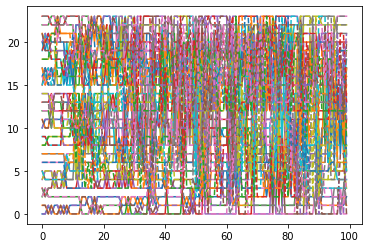

In [11]:
plt.plot(rep_index_pl[:100])
plt.plot(my_rep_index, '--')

[ 9  9  5  5  5  5  5 22 23 23 11 23 23 11 11  7  9 11 11 11 11  9 23 23
 17 23  9  9 23 17 17 23  9  5  5 23  9 23 23 23 17 11 21 17 21 11 17 17
 11 21 17 21 21  6  6  6  6 21  6  6  9  6  9  9  9  9 21 21 23 23 23 11
 23 23 21 17 21 17  5  5  5  5  6  6  2  6 21  5  6  6  5  6  6  6  7  6
  6 11  6 12 12  7 11 11 11  7  7 11 11 11 11  7  7 22  7  7  7  7 23 12
 22 12  7  7  7  7 12  7 22  7  2  2 10  2  2 18 23  6 10 21 21 21 21  6
  2  2  6 21 12 21 21 10 10 10 12 23  2 18 23 12 23  2  2 23 18 10 10  6
  2 10  5  5 10 10 10 12 12 12 12 12  6 12 12  6  6 10  6 23 23 23 23 21
 21 21 23 21 23  5 23  5  5  5  5  6 12 12  6  6 10  5  5  5 23 23 10 10
 10 10 10 18 18 21 21 18 18 10  9  9 21 21 10 10 10 10 10 22 23 23 20  7
  5  5  7  7 22 22 18 18 22 10 22 22 10 18 18 22 10 10 22 22 10 10  7 10
 10  5  5  5  5  7  7 23 23 10 23 23 23  5 23  4  5  4  4  4  9  4  5  4
  4  5  4  4  4  6  6  5  5  5 10 10  5  5  5  5 10 12 20 20 20 20 12 20
 20 20 20 12 12 12 23 23 20 20 20 23  5  5 12 12  5

Text(0.5, 1.0, 'replica_index at T = 18')

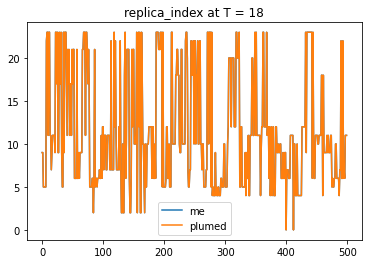

In [79]:
n_temp = 18
sup = 9500
inf = 9000

print(my_rep_index[inf:sup, n_temp])

print(rep_index_pl[inf:sup, n_temp])

plt.plot(my_rep_index[inf:sup, n_temp], '-', label='me')
plt.plot(rep_index_pl[inf:sup, n_temp], '-', label='plumed')
plt.legend()
plt.title('replica_index at T = %i' % n_temp)

# plt.savefig('compare_replica_index.pdf', format='pdf', bbox_inches='tight')

In [25]:
my_rep_temp = np.argsort(my_rep_index, axis=1)
rep_temp_pl = np.argsort(rep_index_pl, axis=1)

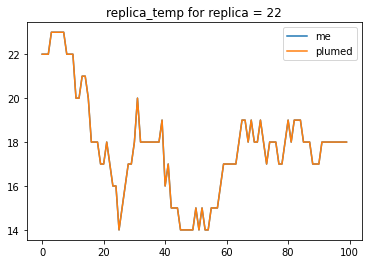

In [26]:
n_replica = 22

plt.title('replica_temp for replica = %i' % n_replica)
plt.plot(my_rep_temp[:, n_replica], '-', label='me')
plt.plot(rep_temp_pl[:100, n_replica], '-', label='plumed')
plt.legend()
plt.show()

so, those which overlap are those starting with the same value at position 0 !!

### look at the trajectory
to fix the threshold

In [10]:
trajs = get_trajectory(n_replicas, paths_traj, start_frame)

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90


In [12]:
print(trajs[0].shape)

(24, 37164)


(array([  21.,   29.,   74.,   75.,  126.,  151.,  137.,  120.,   92.,
         103.,   76.,   76.,   78.,   65.,   44.,  113.,   82.,  130.,
         119.,  138.,  126.,  188.,  176.,  168.,  209.,  186.,  138.,
         154.,  171.,  156.,  142.,  158.,  165.,  125.,  197.,  178.,
         258.,  308.,  427.,  560.,  597.,  751.,  833.,  951., 1132.,
        1361., 1477., 1646., 1839., 1948., 1992., 1871., 1680., 1544.,
        1325., 1125.,  922.,  839.,  691.,  550.,  405.,  379.,  289.,
         263.,  197.,  179.,  181.,  178.,  142.,  166.,  174.,  222.,
         204.,  180.,  190.,  196.,  173.,  239.,  227.,  181.,  158.,
         164.,  146.,  106.,   87.,   58.,   61.,   44.,   67.,   79.,
          86.,   89.,   83.,   81.,  100.,   98.,   73.,   60.,   34.,
          12.]),
 array([-50.620003  , -49.606304  , -48.5926    , -47.578903  ,
        -46.5652    , -45.551502  , -44.537804  , -43.5241    ,
        -42.510403  , -41.4967    , -40.483     , -39.469303  ,
        -3

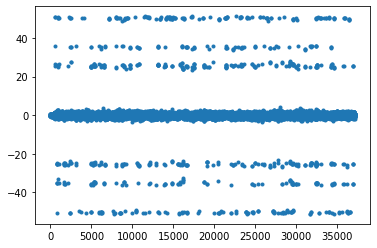

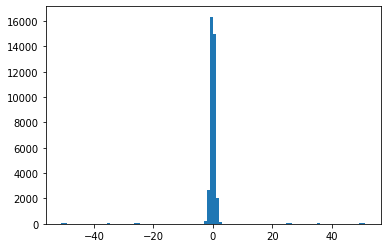

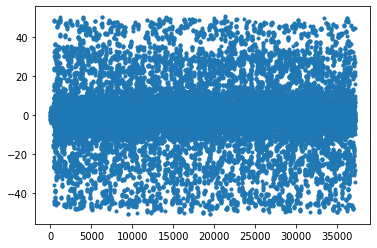

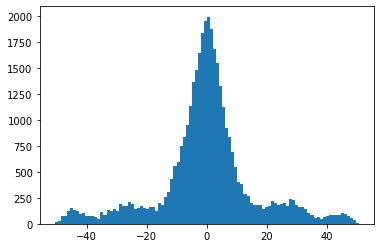

In [24]:
i = 50

single_diff = trajs[i][1] - trajs[i - 1][0]

plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

single_diff = trajs[i][1] - trajs[i - 1][1]

plt.figure()
plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

[[229.  33.  11.  29.  10.  10.   4.   7.  13.  10.   7.  17.   6.  12.
    8.  13.  10.   6.  12.   7.   9.  10.   9.   6.]
 [ 32. 252.  19.  22.  10.  14.   7.   5.   7.  12.   7.   6.   5.   6.
   11.   6.   7.   8.  12.   7.  12.  12.   6.   4.]
 [ 18.  21.  24. 210.  11.  16.  11.  10.   7.  11.  12.  12.   7.   8.
    5.   6.   7.  13.  10.   9.  13.   6.   7.   6.]
 [ 11.  17. 199.  24.  22.  28.  14.   5.   7.   5.  11.  10.   4.  15.
    9.   9.   9.   8.  13.   6.   5.   6.   4.  14.]
 [ 11.  15.  18.  20.  24. 202.  14.  16.  14.  10.   7.   5.   8.  11.
    6.   6.   4.   7.   9.  12.   5.  11.  10.   5.]
 [  8.   8.  23.  16. 195.  20.  21.  13.  11.   9.  12.   5.   3.   5.
   15.   3.   9.   6.   6.   9.   6.   8.  14.   3.]
 [  6.  11.   9.  16.  21.  22. 228.  22.  13.   7.   9.   4.   6.   9.
   10.   6.   6.  10.   5.   7.  17.   7.  12.   9.]
 [  8.  11.  12.  11.  12.   9.  16. 173.  20.  11.  10.  10.   8.   9.
    5.   9.  12.   9.   6.   8.   9.   9.   5.  10.]


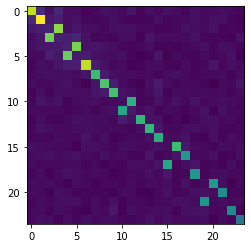

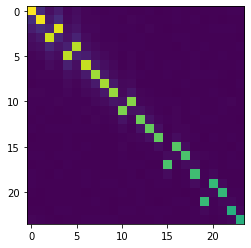

In [19]:
i = 1

for threshold in [1e-3, 1]:
    diff, ind = main_demuxing(trajs[i - 1], trajs[i], threshold=threshold)

    print(diff)

    plt.figure()
    plt.imshow(diff)